- 오디오관련 알고리즘을 체험해보고 공부해보는 생각을 가지고 간단하게 해봤습니다.
- 개선점이 많을 것으로 생각되고 틀린내용이 존재할 수도 있음에 양해부탁드립니다.
- colab basic을 통해 학습했습니다.

#  1. 환경구축

###  필요 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob


import librosa
import librosa.display as dsp
import IPython.display as ipd

warnings.filterwarnings(action='ignore')


###  시드고정

In [2]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

# 2. 오디오 데이터 불러오기

### Sampling rate
- sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
- 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남
- 일반적으로 인간의 청각영역은 8 kHz(8000 sample/second)이고
- sampleing rate는 2배 커져 16000으로 설정한다고함 librosa에서의 기본값은 22050
- 하지만 더 나은 해상도를 위해 좀 더 여유롭게 20000으로 설정함

In [3]:
sr = 32000

몇 개의 데이터를 샘플링하여 살펴보면 모두 다른 길이를 가지고 있음
길이를 맞춰야 함을 의미

In [4]:
for i in os.listdir('./data/train')[:3]:
  print(f'{i}')
  data, sample_rate = librosa.load(f'./data/train/{i}', sr=sr)
  print('sample_rate:', sample_rate, ', audio shape:', data.shape)
  print('length:', data.shape[0]/float(sample_rate), 'secs')
  print('\n')

AAACWKPZ.ogg
sample_rate: 32000 , audio shape: (44136,)
length: 1.37925 secs


AAAQOZYI.ogg
sample_rate: 32000 , audio shape: (32152,)
length: 1.00475 secs


AAAWBXQE.ogg
sample_rate: 32000 , audio shape: (76902,)
length: 2.4031875 secs




In [9]:
from tqdm.notebook import tqdm

train_file_names = (train["id"].astype(str) + '.ogg').to_numpy()

test_file_names = (test["id"].astype(str) + '.ogg').to_numpy()
target = train["label"].to_numpy()

def load_audio(id, target, path):   
  audios = []
  for audio in tqdm(id):
    # librosa를 이용하여 데이터 로드
    an_audio, _ = librosa.load(path+audio, sr=sr)
    audio_array = np.array(an_audio)
    audios.append(audio_array)
  audios = np.array(audios)

  targets = target.copy()

  return audios, targets

In [10]:
audio_train, target_train = load_audio(train_file_names, target, path='./data/train/')
audio_test, _ = load_audio(test_file_names, np.array([None]), path='./data/test/')

  0%|          | 0/55438 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

# 3. 오디오 데이터 feature 추출

- 오디오데이터로부터 그래프를 얻고 이를 이미지로 표현해 cnn모델에 넣어 분류하고자 함

- 자주 사용한다고 하는 melspectrogram, mfcc 두가지 방법을 이용해 특징 추출


### 1) melspectrogram
- 사람은 낮은 주파수를 높은 주파수보다 더 예민하게 받아들임

- 500 ~ 1500 Hz 가 바뀌는건 예민하게 인식하는데 반해 10000Hz ~ 11000Hz가 바뀌는 것은 잘 인식 못한다는 것. 

- 주파수 단위를 다음 공식에 따라 멜 스케일로 변환
$$
m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)
$$

- 해당 scale을 적용해 spectogram을 만든 것이 melspectogram


### 2) mfcc

- Mel-Spectrogram이라는 피쳐에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행


### 3) melspectrogram vs mfcc
- Mel-Spectrogram의 경우 주파수끼리 Correlate하기 때문에 도메인이 한정적인 문제에서 더 좋은 성능을 보이고,
- MFCC의 경우는 De-Correlate를 해주기 때문에 일반적인 상황에서 더 좋은 성능을 보여준다고 함.


- 출처 https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sooftware&logNo=221661644808

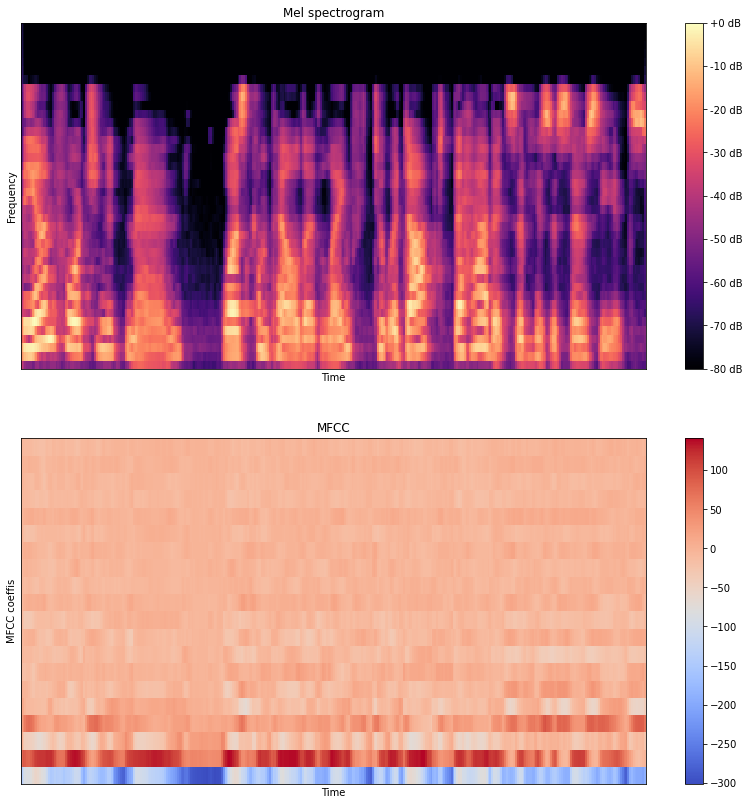

In [12]:
plt.figure(figsize=(14,14))
ax = plt.subplot(2, 1, 1)


ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()

### 4) padding

- 오디오들의 길이가 같지 않기때문에 melspectrogram과 mfcc 모두 길이가 제각각
- 여유로운 크기의 고정 사이즈를 정하고 
- 고정사이즈에 맞추어 랜덤으로 앞이나 뒤에 padding을 실시

- 각각 파일마다 데시벨의 차이가 있을 것이라 생각하고 파일마다 min_max_scale 실시
- padding이전에 scale할것인가 이후에 할 것인가는 각 featureset의 아웃풋 이미지를보고 색이 적절한 것을 선택 (옳은 방법이 아닐수도)

#### ** translation invariance
- CNN에서 translation invariance란 input의 위치가 달라져도 output이 동일한 값을 갖는것
- 분류에 cnn모델을 적용할 것이기 때문에 padding 적용가능

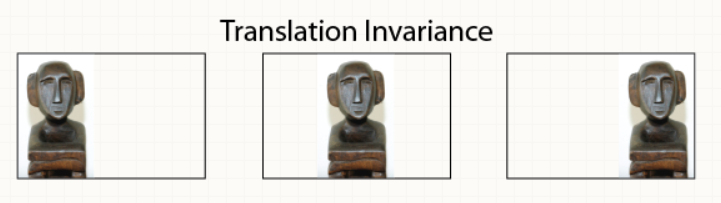

In [17]:
def random_pad(mels, pad_size, mfcc=False):
    # Calculate left and right padding sizes
    if mfcc:
        feature_size = mels.shape[0]  # Number of MFCC coefficients
    else:
        feature_size = mels.shape[0]  # Number of mel bins
    
    # Ensure pad_size is within bounds
    pad_size = min(pad_size, feature_size // 2)
    
    # Generate random padding sizes
    left = np.random.randint(0, pad_size + 1)
    right = pad_size - left
    
    # Normalize mels if needed
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min) / (local_max - local_min)
    
    # Pad mels array
    mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')
    
    return mels

- 가장 긴 파일의 오디오정보가 잘리지 않을 정도의 pad_size를 설정
- 즉, pad_size는 sample rate에 따라 달라질 것
- melspectrogram과 mfcc의 n은 리턴값이 정사각형이 될 수 있도록 같은 40 설정 
- 리턴값이 커질수록 feature의 값이 많아지는 것이기 때문에 성능에 영향을 미칠 것으로 예상

In [18]:
size = 40
pad_size = 40
repeat_size = 5

- train에는 data agumentation이 될 것이라고 생각하고 하나의 파일에 5번 padding을 이용해 생성 

In [ ]:
audio_mels = []
audio_mfcc = []

for y in audio_train:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [20]:
audio_mels_array_test = []
audio_mfcc_array_test = []

for y in audio_test:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

  audio_mels_array_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
  audio_mfcc_array_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

- librosa로 리턴된값은 바로 모델에 들어갈 수 없기 때문에 np.array로 변환
- 각각 melspectrogram, mfcc 데이터 셋이 생성됨

In [34]:


audio_mels_array = np.array(audio_mels, dtype=np.float64)
print("audio_mels_array shape:", audio_mels_array.shape)
audio_mfcc_array = np.array(audio_mfcc, dtype=np.float64)
print("audio_mfcc_array shape:", audio_mfcc_array.shape)
audio_mels_array_test = np.array(audio_mels_array_test, dtype=np.float64)
audio_mfcc_array_test = np.array(audio_mfcc_array_test, dtype=np.float64)
print("audio_mels_array_test shape:", audio_mels_array_test.shape)
print("audio_mfcc_array_test shape:", audio_mfcc_array_test.shape)

KeyboardInterrupt: 

- 위의 두줄은 melspectrogram로 생성한 이미지
- 아래 두줄은 mfcc로 생성한 이미지

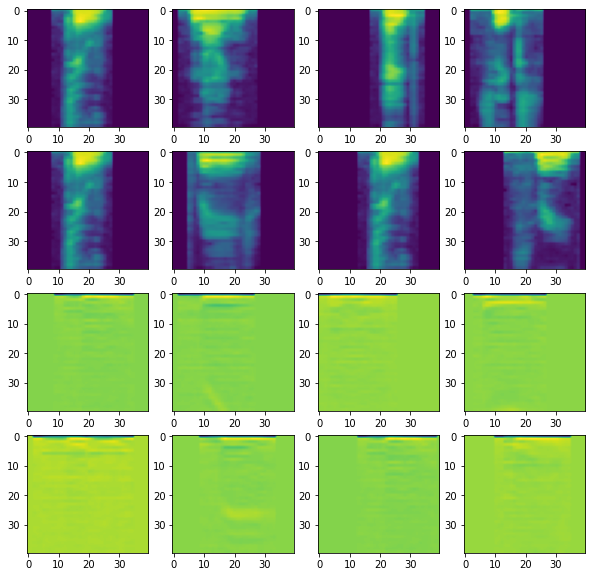

In [ ]:
target_num = 2
target_num_idx = np.where(target_train==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

- 증강한 데이터만큼 target값도 복제

In [11]:
from sklearn.model_selection import train_test_split

repeated_target = np.repeat(target_train,repeat_size)
x_train, x_val, y_train, y_val = train_test_split(audio_cqt_array, repeated_target, test_size=0.2, random_state=813, stratify=repeated_target)

NameError: name 'repeat_size' is not defined

# Model

- pre-trained 모델 사용이 불가능
- audio분야에서 많이 사용된다는 resnet의 resblock을 응용하여 작은 모델 생성
- audio학습에 대한 체험이 목적이기에 modeling에 큰 힘을 쏟지 않음
- 타모델들을 같이 사용하여  emsenble한다면 성능 향상 예상

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [ ]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

  outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool2D((2,2))(outputs)

  outputs = residual_block(outputs, 16, 32)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 32, 32)
  # outputs = residual_block(outputs, 32, 32)
  outputs = residual_block(outputs, 32, 64)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 64, 64)
  # outputs = residual_block(outputs, 64, 64)
  # outputs = MaxPool2D((2,2))(outputs)

  outputs = GlobalAveragePooling2D()(outputs)
  # outputs = Flatten()(outputs)

  outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(2,activation='softmax')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# model = build_model()
# model.summary()

# 학습
- 5-fold StratifiedKFold 실시 및
- 같은 모델을 melspectrogram, mfcc featureset에 학습시켜 emsenble

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, repeated_target)):

  print(f'\n********** {fold+1} fold **********')

  preds_val_list = []
  ### melspectrogram ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mels_array[train_index], audio_mels_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mels_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mels_array_test))
  print(f'mels_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### mfcc ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mfcc_array[train_index], audio_mfcc_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mfcc_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mfcc_array_test))
  print(f'mfcc_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### ensemble ###
  val_pred_result = preds_val_list[0].copy()
  for i in range(1, len(preds_val_list)):
      val_pred_result += preds_val_list[i]
  val_pred_label = np.argmax(val_pred_result, axis=1)
  en_acc = accuracy_score(y_val,val_pred_label)
  acc_list.append(en_acc)
  print(f'ensemble_model_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
mels_model_acc : 0.9500
mfcc_model_acc : 0.9650
ensemble_model_acc : 0.9875

********** 2 fold **********
mels_model_acc : 0.9525
mfcc_model_acc : 0.9250
ensemble_model_acc : 0.9675

********** 3 fold **********
mels_model_acc : 0.9175
mfcc_model_acc : 0.9550
ensemble_model_acc : 0.9750

********** 4 fold **********
mels_model_acc : 0.9600
mfcc_model_acc : 0.9300
ensemble_model_acc : 0.9775

********** 5 fold **********
mels_model_acc : 0.9225
mfcc_model_acc : 0.9575
ensemble_model_acc : 0.9750


mean_acc : 0.9765


- 한개의 featureset을 이용한 것 보다 ensemble이 더 나은 성능들을 보임

In [ ]:
test_pred_result = pred_list[0].copy()
for i in range(1, len(pred_list)):
    test_pred_result += pred_list[i]

submission['label'] = np.argmax(test_pred_result, axis=1)
submission.head()
submission.to_csv('./0615_1.csv', index=False) 